In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from sklearn.metrics import classification_report

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers import Embedding, Dense, Lambda
from keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [7]:
n_tags = 2

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [9]:
X_tra = np.array([sentence['sentence'].replace('\n', '').strip() 
                  for article in train_data 
                  for sentence in article['sentences']])
X_val = np.array([sentence['sentence'].replace('\n', '').strip() 
                  for article in valid_data 
                  for sentence in article['sentences']])
X_test = np.array([sentence['sentence'].replace('\n', '').strip() 
                   for article in test_data 
                   for sentence in article['sentences']])

In [10]:
y_tra = to_categorical(np.array([sentence['label'] 
                                 for article in train_data 
                                 for sentence in article['sentences']]))
y_val = to_categorical(np.array([sentence['label'] 
                                 for article in valid_data 
                                 for sentence in article['sentences']]))
y_test = np.array([sentence['label'] for article in test_data for sentence in article['sentences']])

### Load ELMo

In [11]:
sess = tf.Session()
K.set_session(sess)

In [12]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Flat Model

In [13]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [14]:
def build_flat_model_1():
    
    input_text = Input(shape=(1,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    
    pred = Dense(2, activation='sigmoid')(dense)
    
    return Model(inputs=[input_text], outputs=pred)

In [16]:
model_name = 'RQ1_elmo_flat_model_1'
model = build_flat_model_1()
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 656,642
Trainable params: 656,642
Non-trainable params: 0
_________________________________________________________________


### Train

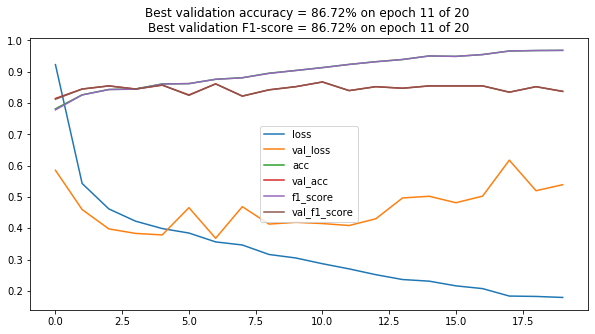

In [17]:
## Flat Model Fit
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)])

### Test

In [18]:
y_preds = model.predict(X_test, batch_size=32)

In [19]:
y_preds = np.argmax(y_preds, axis=1)

In [20]:
### build_flat_model_1 results
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       325
           1       0.83      0.47      0.60       116

   micro avg       0.84      0.84      0.84       441
   macro avg       0.84      0.72      0.75       441
weighted avg       0.84      0.84      0.82       441

